# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 4 - Neural Netoworks Training - Supervised

The goal of the Laboratory 4 is to:
<ul>
  <li> Familarize yourself with the gradient descent algorithm.
  <li> Get familiar with the neural network training process.
  <li> Train a neural network for the classification of brain tumors in the MRI images.
  <li> Understand the training hyperparameters: batch size, number of epochs, learning rate.
</ul>

You are going to: (i) implement the gradient descent algorithm in PyTorch, (ii) implement a simple convolutional network architecture, (iii) train the neural network using the supervised strategy (for image classification).

### Part I - Gradient Descent

The first part of the laboratory is not directly connected with the neural network training process but it is useful to understand the general concept.

You will start by implementing a simple version of the gradient descent algorithm. You can build the intuition by reading: 

http://mlwiki.org/index.php/Gradient_Descent

The gradient algorithm is the predecessor of the state-of-the-art optimization methods used to train the deep neural network like SGD or Adam - the methods you will use in the next parts of the laboratory. It is a first order gradient-based optimization method.

Let's start by generating a simple function. Your task will be to find the minimum of the function by the gradient descent (using PyTorch).

In [130]:
import numpy as np
import torch as tc
import torch
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
def gradient_descent(f, initial_guess, num_iters, learning_rate, echo=False):
    step = 0.001
    result = initial_guess.clone().detach().requires_grad_(True)  
    for i in range(num_iters):
        
        gradient = tc.zeros_like(initial_guess)
        for j in range(len(initial_guess)):
            
            perturbation = tc.zeros_like(initial_guess)
            perturbation[j] = step
            forward_step = f(*((result + perturbation).unbind()))
            backward_step = f(*((result - perturbation).unbind()))
            gradient[j] = (forward_step - backward_step) / (2 * step)

        
        result = result - learning_rate * gradient

        if echo:
            
            print(f"Iteration {i + 1}: Result = {result}, Function Value = {f(*((result).unbind()))}")

    return result

Now let's verify the implementation:

In [133]:
f = lambda x, y: x**2 + y**2
initial_guess = tc.randn(2).type(tc.float32) 
num_iters = 50
learning_rate = 0.1
echo = True

result = gradient_descent(f, initial_guess, num_iters, learning_rate, echo)
print(f"Initial arguments: {initial_guess}, Value of the function for the initial arguments: {f(*initial_guess)}")
print(f"Result: {result}, Value of the function at the result: {f(*result)}")

Iteration 1: Result = tensor([ 0.0666, -0.1228], grad_fn=<SubBackward0>), Function Value = 0.019514627754688263
Iteration 2: Result = tensor([ 0.0533, -0.0982], grad_fn=<SubBackward0>), Function Value = 0.012489348649978638
Iteration 3: Result = tensor([ 0.0426, -0.0786], grad_fn=<SubBackward0>), Function Value = 0.007993184030056
Iteration 4: Result = tensor([ 0.0341, -0.0629], grad_fn=<SubBackward0>), Function Value = 0.0051156338304281235
Iteration 5: Result = tensor([ 0.0273, -0.0503], grad_fn=<SubBackward0>), Function Value = 0.003274005837738514
Iteration 6: Result = tensor([ 0.0218, -0.0402], grad_fn=<SubBackward0>), Function Value = 0.0020953649654984474
Iteration 7: Result = tensor([ 0.0175, -0.0322], grad_fn=<SubBackward0>), Function Value = 0.0013410348910838366
Iteration 8: Result = tensor([ 0.0140, -0.0258], grad_fn=<SubBackward0>), Function Value = 0.0008582625887356699
Iteration 9: Result = tensor([ 0.0112, -0.0206], grad_fn=<SubBackward0>), Function Value = 0.0005492880

You can observe that the function became a bit unstable during the last iterations. This is connected with the learning rate: (i) if the learning rate is too high the function can become unstable, (ii) if the learning rate is too low the time required for optimization will be longer.

Verify the effect of the learning rate:

In [134]:
initial_guess = tc.randn(2).type(tc.float32) 
num_iters = 50
learning_rate_low = 0.01
learning_rate_medium = 0.1
learning_rate_high =  10
echo = True

print()
result_lr_low = gradient_descent(f, initial_guess, num_iters, learning_rate_low, echo)
print()
print(f"Result: {result}, Value of the function at the result: {f(*result_lr_low)}")

print()
result_lr_medium = gradient_descent(f, initial_guess, num_iters, learning_rate_medium, echo)
print()
print(f"Result: {result}, Value of the function at the result: {f(*result_lr_medium)}")

print()
result_lr_high = gradient_descent(f, initial_guess, num_iters, learning_rate_high, echo)
print()
print(f"Result: {result}, Value of the function at the result: {f(*result_lr_high)}")


Iteration 1: Result = tensor([-0.5018, -0.1115], grad_fn=<SubBackward0>), Function Value = 0.2642495334148407
Iteration 2: Result = tensor([-0.4918, -0.1093], grad_fn=<SubBackward0>), Function Value = 0.25378522276878357
Iteration 3: Result = tensor([-0.4819, -0.1071], grad_fn=<SubBackward0>), Function Value = 0.24373547732830048
Iteration 4: Result = tensor([-0.4723, -0.1049], grad_fn=<SubBackward0>), Function Value = 0.23408366739749908
Iteration 5: Result = tensor([-0.4629, -0.1028], grad_fn=<SubBackward0>), Function Value = 0.2248140424489975
Iteration 6: Result = tensor([-0.4536, -0.1008], grad_fn=<SubBackward0>), Function Value = 0.21591152250766754
Iteration 7: Result = tensor([-0.4445, -0.0988], grad_fn=<SubBackward0>), Function Value = 0.20736151933670044
Iteration 8: Result = tensor([-0.4356, -0.0968], grad_fn=<SubBackward0>), Function Value = 0.19915014505386353
Iteration 9: Result = tensor([-0.4269, -0.0948], grad_fn=<SubBackward0>), Function Value = 0.19126388430595398
It

You can observe that for the low learning rate the function requires more iterations to converge, the medium learning rate is more or less acceptable, while the high learning rate led to an unstability during the training process.

Next, let's implement the gradient descent again, however, this time use the PyTorch Autograd to calculate the gradient.

You may find useful to first read:

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [135]:
def gradient_descent_autograd(f, initial_guess, num_iters, learning_rate, echo=False):
    result = tc.tensor(initial_guess, requires_grad=True, dtype=tc.float32)  
    for i in range(num_iters):
        
        loss = f(result)
        gradient = tc.autograd.grad(loss, result, create_graph=True)[0]
        
        result = result - learning_rate * gradient

        if echo:
            
            print(f"Iteration {i + 1}: Result = {result}, Function Value = {loss.item()}")

    return result

Verify the correctness. Moreover, compare the running time with the previously implemented function (with echo = False).

In [136]:
initial_guess = tc.randn(2).type(tc.float32)
num_iters = 50
learning_rate = 0.1
echo = False

start_time = time.time()
result = gradient_descent(f, initial_guess, num_iters, learning_rate, echo)
end_time = time.time()
print(f"Execution time for gradient_descent: {end_time - start_time} seconds")


start_time = time.time()
f = lambda x: x[0]**2 + x[1]**2
result_autograd = gradient_descent_autograd(f, initial_guess, num_iters, learning_rate, echo)
end_time = time.time()
print(f"Execution time for gradient_descent_autograd: {end_time - start_time} seconds")

Execution time for gradient_descent: 0.02000117301940918 seconds
Execution time for gradient_descent_autograd: 0.013000726699829102 seconds


C:\Users\Mateleo\AppData\Local\Temp\ipykernel_1264\2686043779.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = tc.tensor(initial_guess, requires_grad=True, dtype=tc.float32)


You can see that both the method work. However, the Autograd outputs more accurate results. The reason for this is connected with the fact that Autograd attempts to configure the gradient as accurately as possible (e.g. by choosing a dedicated gradient step). A speed-up compared with the naive gradient approximiation could be observed with more real-like problems (more variables) and using GPUs.

### Part II - Convolutional Neural Network

Let's now implement a simple neural network. Following the knowledge and skills you gained during Laboratory 2.

Implement a neural network with the following architecture:

<ul>
  <li> Conv2D with:
    <ul>
      <li> Input channels: 1
      <li> Output channels: 32
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 32
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 1
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Adaptive Average Pooling to size (B, 128, 1, 1)
  <li> Linear layer with input size: 64, and output size: 64
  <li> ReLU activation function
  <li> Linear layer with input size: 64 and output size: 64
  <li> ReLU activation function
  <li> Linear layer with input size: 64 and output size: 4
</ul>

In [137]:
class ClassificationNetwork(nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()

        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=2)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=2)
        self.batch_norm5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(64)
        self.relu6 = nn.ReLU()

        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        
        self.fc1 = nn.Linear(64, 64)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(64, 64)
        self.relu_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.relu1(self.batch_norm1(self.conv1(x)))
        x = self.relu2(self.batch_norm2(self.conv2(x)))
        x = self.relu3(self.batch_norm3(self.conv3(x)))
        x = self.relu4(self.batch_norm4(self.conv4(x)))
        x = self.relu5(self.batch_norm5(self.conv5(x)))
        x = self.relu6(self.batch_norm6(self.conv6(x)))

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))
        x = self.fc3(x)

        return x

And generate random input to the verify whether the neural networks processes the input correctly:

In [138]:
classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 1, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(classification_network.to(device), (1, 224, 224))

Size of the random input: torch.Size([4, 1, 224, 224])
Size of the random output: torch.Size([4, 4])
Random output: 
tensor([[ 0.0199, -0.0919,  0.0318,  0.1086],
        [ 0.0210, -0.0897,  0.0265,  0.1025],
        [ 0.0197, -0.0919,  0.0264,  0.1081],
        [ 0.0145, -0.0968,  0.0373,  0.1139]], grad_fn=<AddmmBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 113, 113]          18,496
       BatchNorm2d-5         [-1, 64, 113, 113]             128
              ReLU-6         [-1, 64, 113, 113]               0
            Conv2d-7         [-1, 64, 113, 113]          36,928
       BatchNorm2d-8         [-1, 64, 113, 113]             128
             

### Part III - Dataset, Dataloader

You are going to use the dataset from the Laboratory 3 dedicated to tumor classification in the MRI images. Mount the google drives, create the pathes and copy-paste the dataloader (the extended version) to the cell below:

In [139]:
class BrainDataset(Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False, target_size=(224, 224)):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.transforms = transforms
        self.z_norm = z_norm
        self.target_size = target_size

        
        self.dataframe = pd.read_csv(csv_path)

        if self.z_norm:
            
            self.mean = self.dataframe['image_pixels'].mean()
            self.std = self.dataframe['image_pixels'].std()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        current_image_path = self.dataframe.iloc[idx]['image_path']
        current_class = self.dataframe.iloc[idx]['image_class_number']

        
        current_image = Image.open(current_image_path)

        
        current_image = current_image.resize(self.target_size, Image.ANTIALIAS)

        
        current_image = current_image.convert("L")

        if self.transforms is not None:
            current_image = self.transforms(current_image)

        
        current_image = transforms.ToTensor()(current_image)

        
        if self.z_norm:
            current_image = (current_image - self.mean) / self.std

        return current_image, current_class

In [140]:
batch_size = 16
shuffle = True
training_csv_path = "./lab3_data/training.csv"
testing_csv_path = "./lab3_data/testing.csv"
dataset_path = "./lab3_data"

training_dataset = BrainDataset(os.path.join(dataset_path, "training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

Verify whether the data is being loaded correctly:

C:\Users\Mateleo\AppData\Local\Temp\ipykernel_1264\1998987783.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  current_image = current_image.resize(self.target_size, Image.ANTIALIAS)


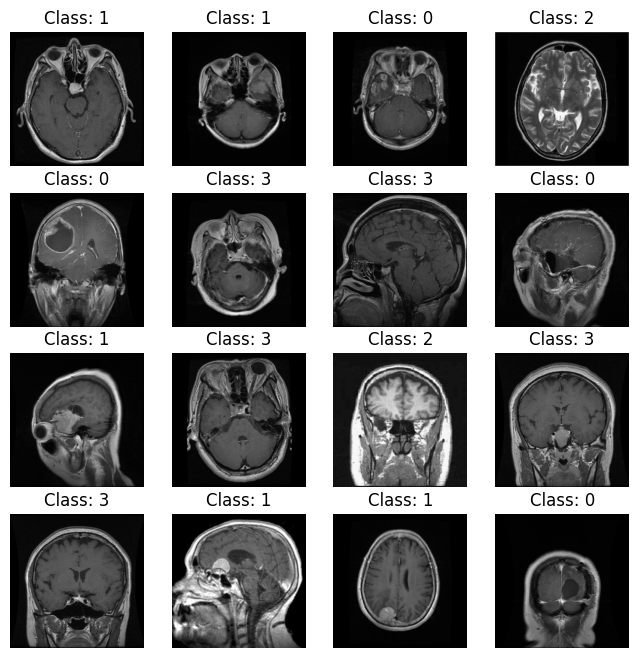

In [141]:
for images, classes in training_dataloader:
    
    num_images = len(images)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(num_images):
        row = i // 4
        col = i % 4

        image = F.to_pil_image(images[i])
        
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].set_title(f'Class: {classes[i]}')
        axs[row, col].axis('off')

    plt.show()
    break  

### Part IV - Network Training

Now it's the time to train the neural network. During this laboratory you are going to do this in a supervised manner. It means that the ground-truth labels will be provided during the training process to guide the network parameters into local minima of the objective function dedicated to image classification.

This time you will analyze the training process in a simplified way by accumulating and visualizing the process using matplotlib. More advanced TensorBoard logging will be the task during the next Laboratory.

Start with creating the training function. 

In [142]:
def training(model, training_dataloader, testing_dataloader, training_params):
    num_epochs = training_params['num_epochs']
    learning_rate = training_params['learning_rate']

    objective_function = nn.CrossEntropyLoss()  
    parameters = model.parameters()  
    optimizer = optim.Adam(parameters, lr=learning_rate)  

    training_losses = []
    testing_losses = []
    model = model.to(device)  

    print(f"Training dataset size: {len(training_dataloader.dataset)}")
    print(f"Testing dataset size: {len(testing_dataloader.dataset)}")
    
    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch}")

        training_epoch_loss = 0.0
        model.train()

        for images, classes in training_dataloader:
            images, classes = images.to(device), classes.to(device)  
            optimizer.zero_grad()  
            output = model(images)  
            loss = objective_function(output, classes)  
            loss.backward()  
            optimizer.step()  
            training_epoch_loss += loss.item()

        training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
        training_losses.append(training_epoch_loss)
        print(f"Current epoch training loss: {training_epoch_loss}")

        testing_epoch_loss = 0.0
        model.eval()

        for images, classes in testing_dataloader:
            images, classes = images.to(device), classes.to(device)  
            with tc.no_grad():
                output = model(images)  
                loss = objective_function(output, classes)  
                testing_epoch_loss += loss.item()

        testing_epoch_loss = testing_epoch_loss / len(testing_dataloader.dataset)
        testing_losses.append(testing_epoch_loss)
        print(f"Current epoch testing loss: {testing_epoch_loss}")

    
    return model, training_losses, testing_losses


Now define the training hyperparameters and create the training/testing dataloader (note: during this laboratory you not have the validation dataloader and the testing set is used as the validation dataloader, it will be modified during the next Laboratory):

In [143]:
learning_rate = 0.003
batch_size = 64
num_epochs = 50
shuffle = True
model = ClassificationNetwork()

training_params = {
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
}

training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

testing_dataset = BrainDataset(os.path.join(dataset_path, "Testing"), testing_csv_path)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

Run the training:

In [144]:
model, training_losses, testing_losses = training(model, training_dataloader, testing_dataloader, training_params)

Training dataset size: 2296
Testing dataset size: 574
Current epoch: 0


C:\Users\Mateleo\AppData\Local\Temp\ipykernel_1264\1998987783.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  current_image = current_image.resize(self.target_size, Image.ANTIALIAS)


Current epoch training loss: 0.017248869020141375
Current epoch testing loss: 0.019802516968823475
Current epoch: 1
Current epoch training loss: 0.013755325734199962
Current epoch testing loss: 0.016521074942180088
Current epoch: 2
Current epoch training loss: 0.013011231836749286
Current epoch testing loss: 0.013699722726170609
Current epoch: 3
Current epoch training loss: 0.012600589478680481
Current epoch testing loss: 0.012099164495900117
Current epoch: 4
Current epoch training loss: 0.011664608967221157
Current epoch testing loss: 0.037136731870498395
Current epoch: 5
Current epoch training loss: 0.010441761476860644
Current epoch testing loss: 0.04747206824166434
Current epoch: 6
Current epoch training loss: 0.009510631643832769
Current epoch testing loss: 0.053242742807607615
Current epoch: 7
Current epoch training loss: 0.00890376243597539
Current epoch testing loss: 0.042847305224747605
Current epoch: 8
Current epoch training loss: 0.009166349387542712
Current epoch testing lo

And finally visualize the training/validation process by showing the loss during each epoch (as below):

In [145]:
training_losses

[0.017248869020141375,
 0.013755325734199962,
 0.013011231836749286,
 0.012600589478680481,
 0.011664608967221157,
 0.010441761476860644,
 0.009510631643832769,
 0.00890376243597539,
 0.009166349387542712,
 0.007704742097065424,
 0.007354934806919264,
 0.007048970769818236,
 0.006681837738598681,
 0.00702643728058928,
 0.006448390371188885,
 0.006405983684837611,
 0.006270072776629534,
 0.005815831749644844,
 0.00531619963096617,
 0.0053598647190822545,
 0.005281989199826526,
 0.005288710733323978,
 0.005461205692656779,
 0.004703867044754144,
 0.004547955383926319,
 0.004473585800920006,
 0.004000426240862455,
 0.0035979288536081744,
 0.00436914767518328,
 0.0035575151099508646,
 0.003306246430772107,
 0.0032827129185147817,
 0.0028284209397481915,
 0.0030763226428202222,
 0.0035397407731839587,
 0.002783408764918507,
 0.0022545895873461864,
 0.0021955060289088855,
 0.0024624672630730406,
 0.0029859911514128127,
 0.0018211619324904286,
 0.0015681257596375738,
 0.0015114032572544202,
 

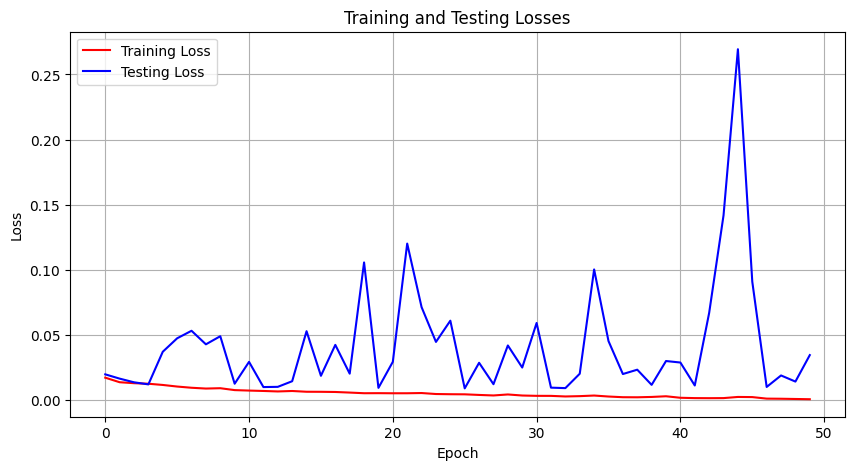

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss', color='red')
plt.plot(range(len(testing_losses)), testing_losses, label='Testing Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

Do you see any problems? What went wrong? What whould happen after inreasing the number of training epochs?

You have just finished the training of the neural network. The next task is to analyze the obtained results.

### Part V - Result Analysis

In the last part of the Laboratory you are going to analyze the results. First, you are going to show the confusion matrices for the training and testing sets. Then, you will visualize the cases for which the network failed.

Start with creating function responsible for accumulating the results. The function should perform a single pass through a dataloader and accumulate all predicitions, together with the corresponding group truth labels.

In [147]:
def accumulate_predictions(model, dataloader):
    predictions = []
    targets = []
    model.eval()

    with tc.set_grad_enabled(False):
        print(f"Dataset size: {len(dataloader.dataset)}")
        for images, classes in dataloader:
            images, classes = images.to(device), classes.to(device)  
            output = model(images)
            predictions.extend(tc.argmax(output, dim=1).cpu().numpy())
            targets.extend(classes.cpu().numpy())

    return predictions, targets


training_predictions, training_targets = accumulate_predictions(model, training_dataloader)
testing_predictions, testing_targets = accumulate_predictions(model, testing_dataloader)


Dataset size: 2296


C:\Users\Mateleo\AppData\Local\Temp\ipykernel_1264\1998987783.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  current_image = current_image.resize(self.target_size, Image.ANTIALIAS)


Dataset size: 574


Now use the function to accumulate the results for training/testing dataloaders and use **sklearn** to show the confusion matrices and classification summary.

Dataset size: 2296


C:\Users\Mateleo\AppData\Local\Temp\ipykernel_1264\1998987783.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  current_image = current_image.resize(self.target_size, Image.ANTIALIAS)


Dataset size: 574


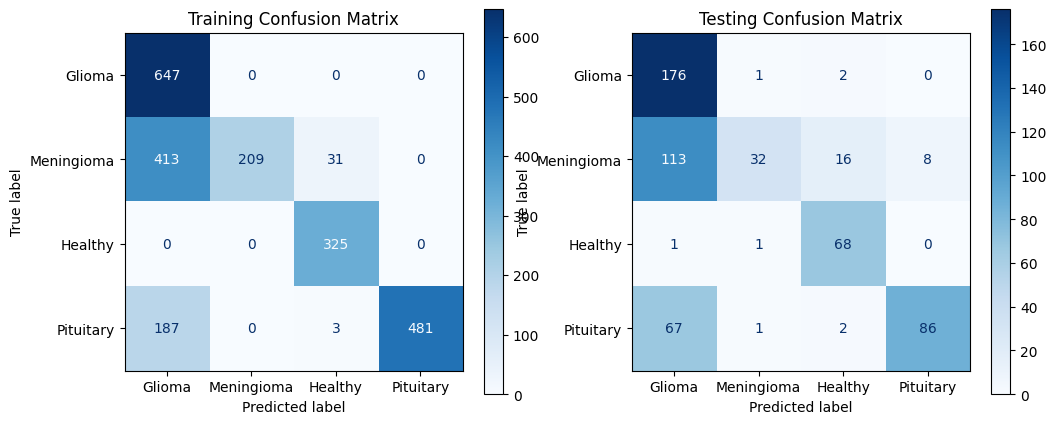

Training Classification Report:
              precision    recall  f1-score   support

      Glioma       0.52      1.00      0.68       647
  Meningioma       1.00      0.32      0.48       653
     Healthy       0.91      1.00      0.95       325
   Pituitary       1.00      0.72      0.84       671

    accuracy                           0.72      2296
   macro avg       0.86      0.76      0.74      2296
weighted avg       0.85      0.72      0.71      2296


Testing Classification Report:
              precision    recall  f1-score   support

      Glioma       0.49      0.98      0.66       179
  Meningioma       0.91      0.19      0.31       169
     Healthy       0.77      0.97      0.86        70
   Pituitary       0.91      0.55      0.69       156

    accuracy                           0.63       574
   macro avg       0.77      0.67      0.63       574
weighted avg       0.77      0.63      0.59       574



In [148]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report


target_names = ["Glioma", "Meningioma", "Healthy", "Pituitary"]


training_predictions, training_targets = accumulate_predictions(model, training_dataloader)
testing_predictions, testing_targets = accumulate_predictions(model, testing_dataloader)


training_predictions = np.array(training_predictions)
training_targets = np.array(training_targets)
testing_predictions = np.array(testing_predictions)
testing_targets = np.array(testing_targets)


training_cm = confusion_matrix(training_targets, training_predictions)
testing_cm = confusion_matrix(testing_targets, testing_predictions)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


metrics.ConfusionMatrixDisplay(training_cm, display_labels=target_names).plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Training Confusion Matrix')


metrics.ConfusionMatrixDisplay(testing_cm, display_labels=target_names).plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Testing Confusion Matrix')

plt.show()


print("Training Classification Report:")
print(classification_report(training_targets, training_predictions, target_names=target_names))

print("\nTesting Classification Report:")
print(classification_report(testing_targets, testing_predictions, target_names=target_names))


What went wrong? Why the results for the training set are so different from the testing set?

Finally, prepare the visualization similar to the one below but showing example of incorrectly classified cases. Show next to the given image the real class and the predicted one.

C:\Users\Mateleo\AppData\Local\Temp\ipykernel_1264\1998987783.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  current_image = current_image.resize(self.target_size, Image.ANTIALIAS)


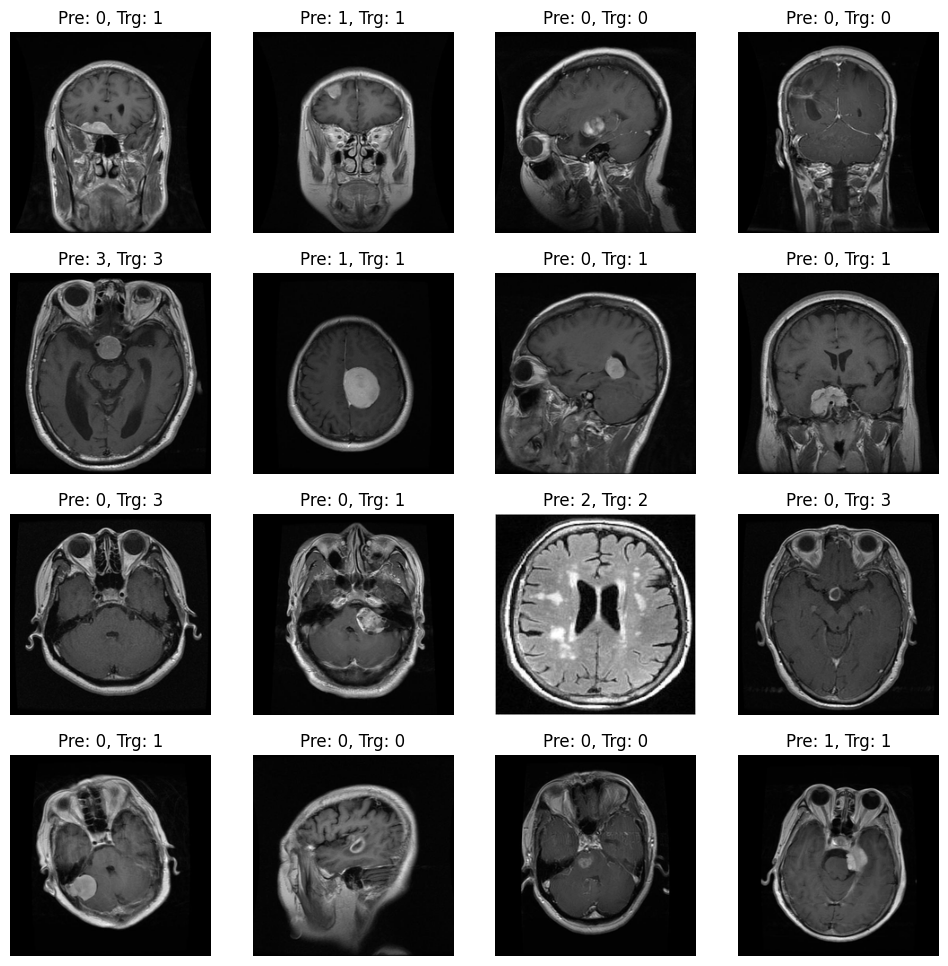

In [149]:
def plot_images(images, predictions, targets, class_names, num_rows=4, num_cols=4):
    
    images = images.cpu().numpy()
    predictions = np.array(predictions)
    targets = targets.cpu().numpy()  

    
    plt.figure(figsize=(12, 12))
    for i in range(min(num_rows * num_cols, images.shape[0])):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')
        plt.title(f'Pre: {predictions[i]}, Trg: {targets[i]}')
        plt.axis('off')

    plt.show()



for images, targets in training_dataloader:
    images, targets = images.to(device), targets.to(device)
    predictions = model(images).argmax(dim=1).cpu().numpy()

    
    plot_images(images, predictions, targets, target_names, num_rows=4, num_cols=4)
    break  


What can you say about the results using the confusion matrices and the visualization? Is the classification working correctly? What's wrong? Do you have any idea how to improve the results? Hint: visually examine the images for each class, both in the training and the testing set.

We will continue the classification topic during the next laboratory using different dataset and a pretrained ResNet18 architecture.

### Conclusion

Congratulations, you have implemented the gradient descent method, the supervised training pipeline and prepared the training setup for the medical image classification.

After the laboratory you should:
<ul>
  <li> Understand the intuition behind the gradient descent method.
  <li> Be able to implement your own training pipeline for the supervised learning.
  <li> Modify the training hyperparameters to verify their influence on the final results.
</ul>

During the next laboratory you are going to extend the knowledge for classification of XRay images by image augmentation, transfer learning from pretrained ResNet18 network, and logging using TensorBoard. You will also extend the evaluation beyond the confusion matrix and simple visualization.